<a href="https://colab.research.google.com/github/isdrael4590/DIALUNG/blob/main/notebooks/ImplementacionModelos/DIALUNG_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquitectura de Red Resnet50
Basado en la librería de [TorchXRayVision]https://github.com/mlmed/torchxrayvision)

In [6]:
import numpy as np
import pandas as pd
import os
mapa_condiciones = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}

In [17]:
!pip install torchxrayvision torchio tqdm torchinfo cockpit-for-pytorch torch-lr-finder

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/My\ Drive/ProyectoDIALUNG/
#Archivo local 
#%cd /media/josejacomeb/Datos1/DatasetsMédicos/ProyectoDIALUNG/

/media/josejacomeb/Datos1/DatasetsMédicos/ProyectoDIALUNG


In [8]:
direccion_dataset_imagenes = "DIALUNG-Datasets/"
dataset_train_256 = os.path.join(direccion_dataset_imagenes, "train_512.hdf5") 
dataset_test_256 = os.path.join(direccion_dataset_imagenes, "test_512.hdf5")
dataset_val_256 = os.path.join(direccion_dataset_imagenes, "val_512.hdf5")

In [9]:
#Tamaño deseado de la imagen
ancho_imagen_deseado  = 512
alto_imagen_deseado =  512
#Variables de rotación
probabilidad_rotacion = 0.20
angulo_rotacion_grados = 45
#Variables de Blur
probabilidad_blur = 0.05
std_filtro_gaussiano = (1, 1)
#Variables de Ruido
probabilidad_ruido = 0.05
std_ruido_gaussiano = (0, 0.08)
mean_ruido_gaussiano = 0
# Variables de Desplazamiento
probabilidad_desplazamiento = 0.20
desplazamiento_x_y = (0.25, 0.25) #1 mm de desplazamiento en ambos ejes 
# Variables de escalado
probabilidad_escalado = 0.20
escalada = (0.85, 0.85)
# Tamaño del batch
batch_size = 2

In [10]:
from torchvision.transforms import Compose #Compose me sirve para apilar varias transformaciones en una sola
from torchvision.transforms import Resize #Cargar herramienta para hacer Rescalado
from torchvision.transforms import Lambda #Convertir tensor de salida a one-hot-encoded 
import torch 
#Librerias de TorchIO
import torchio as tio
#Librerias de DIALUNG
from dialung.utils.creardatasetbinario import crearDatasetBinarioDIALUNG

resize_transform = tio.Resize((alto_imagen_deseado, ancho_imagen_deseado, 1)) #Cambiar el tamaño al establecido en la celda de arriba
normalizacion_dataset = tio.transforms.ZNormalization()
rescalar_intensidad = tio.transforms.RescaleIntensity(out_min_max=(0, 1)) #Rescalar 0 o 1
#Diccionario de transformaciones con su probabilidad de ser ejecutadas
diccionario_transformaciones = {
  tio.RandomAffine(degrees = angulo_rotacion_grados): probabilidad_rotacion, #transformacion de rotación  
  tio.transforms.RandomBlur(std = std_filtro_gaussiano): probabilidad_blur, #transformacion de blur  
  tio.transforms.RandomNoise(mean = mean_ruido_gaussiano, std = std_ruido_gaussiano): probabilidad_ruido, #transformaciones de ruido
  tio.RandomAffine(translation = desplazamiento_x_y): probabilidad_desplazamiento, #transformacion de traslación 
  tio.RandomAffine(scales = escalada): probabilidad_escalado, #probabilidad escalado
}
#Agrupar todas las transformaciones en una sola
transformaciones_DIALUNG = tio.OneOf(diccionario_transformaciones)

transformaciones_dataset = Compose([resize_transform, transformaciones_DIALUNG, rescalar_intensidad]) #Apila las transformaciones
transformacion_salida = Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(int(y)), value=1)) #Hago un

#Creo objetos de tipo crearDatasetDIALUNG
train_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_train_256, transformaciones_dataset, rgb = False)
test_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_test_256, transformaciones_dataset, rgb = False)
val_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_val_256, transformaciones_dataset, rgb = False)

In [11]:
from torch.utils.data import DataLoader #Clase dataloader para cargar en PyTorch los objetos de tipo Dataset

#Creo objetos de tipo DataLoader en lotes de 64 imagenes y barajeados aleatoriamente
train_dataloader = DataLoader(train_datasetDIALUNG, batch_size=batch_size, shuffle=True, num_workers = 2)
test_dataloader = DataLoader(test_datasetDIALUNG, batch_size=batch_size, shuffle=False, num_workers = 2)
val_dataloader = DataLoader(val_datasetDIALUNG, batch_size=batch_size, shuffle=False, num_workers = 2)

In [17]:
from torch import nn
from collections import OrderedDict
from datetime import date
from torch.utils.tensorboard import SummaryWriter

#Configuracion de datos de cada experimento
carpeta_experimentos = "DIALUNG_Experimentos"
carpeta_metricas, carpeta_modelos, carpeta_logs = "Métricas", "Modelos", "logs_dir"
nombre_modelo = "Resnet50Adam" #Poner el nombre cada uno de su modelo
implementado_por= "josejacomeb" #Poner sus nombres 
nombre_experimento = os.path.join(implementado_por, nombre_modelo)
ruta_guardar_metricas = os.path.join(carpeta_experimentos, carpeta_metricas, nombre_experimento)
ruta_guardar_modelos = os.path.join(carpeta_experimentos, carpeta_modelos, nombre_experimento)
ruta_guardar_logs = os.path.join(carpeta_experimentos, carpeta_logs, nombre_experimento)
#Creo los directorios
if not os.path.exists(ruta_guardar_metricas):
    os.makedirs(ruta_guardar_metricas)
if not os.path.exists(ruta_guardar_modelos):
    os.makedirs(ruta_guardar_modelos)
if not os.path.exists(ruta_guardar_logs):
    os.makedirs(ruta_guardar_logs)
#Inicializar TensorBoard para escribir los datos en el directorio de ruta_guardar_logs
writer = SummaryWriter(ruta_guardar_logs)

In [18]:
dispositivo = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(dispositivo))

Using cuda device


In [19]:
import torchxrayvision as xrv #Importar la librería TorchXRayVision
from torch import nn

modelo = xrv.models.ResNet(weights="resnet50-res512-all")
in_features = modelo.model.fc.in_features 
num_clases = len(mapa_condiciones.values())
modelo.op_threshs = None #Previene calibracion del modelo
modelo.model.fc = nn.Linear(in_features=in_features, out_features=num_clases) #Cambio la capa de salida para ajustar a los cuatro parámetros
modelo.to(dispositivo)

XRV-ResNet-resnet50-res512-all

In [20]:
# Obtener algunas imagenes para mostrar en TensorBoard
images, labels = next(iter(val_dataloader))
images = images.to(dispositivo)
#Añadir el modelo a tensorboard
writer.add_graph(modelo, images)

In [21]:
from torchinfo import summary 
print(summary(modelo, input_size = tuple(images.shape)))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        --                        --
├─ResNet: 1-1                                 [2, 4]                    --
│    └─Conv2d: 2-1                            [2, 64, 256, 256]         3,136
│    └─BatchNorm2d: 2-2                       [2, 64, 256, 256]         128
│    └─ReLU: 2-3                              [2, 64, 256, 256]         --
│    └─MaxPool2d: 2-4                         [2, 64, 128, 128]         --
│    └─Sequential: 2-5                        [2, 256, 128, 128]        --
│    │    └─Bottleneck: 3-1                   [2, 256, 128, 128]        75,008
│    │    └─Bottleneck: 3-2                   [2, 256, 128, 128]        70,400
│    │    └─Bottleneck: 3-3                   [2, 256, 128, 128]        70,400
│    └─Sequential: 2-6                        [2, 512, 64, 64]          --
│    │    └─Bottleneck: 3-4                   [2, 512, 64, 64]          379,392

In [30]:
learning_rate_inicial = 0.025
epochs = 75
weight_decay = 1e-4 #Weight decay
learning_rate_manual = None #Poner el numero deseado si se requiere

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.46E-02


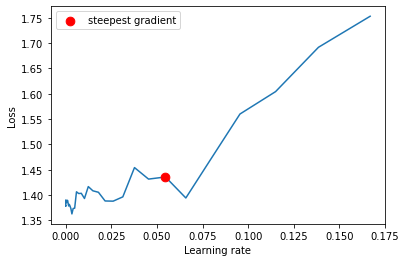

In [29]:
from torch_lr_finder import LRFinder
rango_lr = [1e-7, 100]
busqueda_larga = False
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=rango_lr[0], weight_decay=weight_decay) #Optimizador SGD#torch.optim.Adam(modelo.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = LRFinder(modelo, optimizer, criterion, device=dispositivo)
if busqueda_larga:
  lr_finder.range_test(train_dataloader, val_loader=test_dataloader, end_lr=rango_lr[1], num_iter=100, step_mode="linear")
else:
  lr_finder.range_test(train_dataloader, end_lr=rango_lr[1], num_iter=100)
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [32]:
from torch.optim.lr_scheduler import OneCycleLR
pesos_clase_desbalanceada = torch.tensor([0.5097178 , 2.12377522, 1.0953478 , 1.52830776]).to(dispositivo) 
funcion_perdida = nn.CrossEntropyLoss(weight = pesos_clase_desbalanceada) #Uso de CrossEntropy
optimizador = torch.optim.Adam(modelo.parameters(), lr=learning_rate_inicial, weight_decay=weight_decay) #Optimizador SGD
scheduler = OneCycleLR(optimizador, max_lr= learning_rate_inicial, steps_per_epoch=len(train_dataloader), epochs = epochs)

In [33]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir $ruta_guardar_logs

In [ ]:
from dialung.entrenarvalidar import EntrenamientoValidacionDIALUNG

ruta_ultimo_archivo_pesos = os.path.join(ruta_guardar_modelos, "ultimo.pt") #mejor.pt si algo falló en el proceso
epoch_inicio = 0
resumir_entrenamiento = False
step_inicio = 0
historico = None

if os.path.exists(ruta_ultimo_archivo_pesos):
    resumir_entrenamiento = True
    checkpoint = torch.load(ruta_ultimo_archivo_pesos)
    modelo.load_state_dict(checkpoint["model_state_dict"])#cargar los pesos del modelo
    optimizador.load_state_dict(checkpoint["optimizer_state_dict"]) #carga el modelo del optimizador
    if hasattr(checkpoint, "scheduler_state_dict") and scheduler:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    #Checar por una nuevo lr seleccionado por el usuario
    if learning_rate_manual:
        print("Cambiando el learning rate manualmente a: {}".format(learning_rate_manual))
        optimizador.param_groups[0]["lr"] = learning_rate_manual
    
    epoch_inicio = checkpoint["epoch"]
    step_inicio = checkpoint["steps"]
    historico = checkpoint["historico"]
    print("Resumiendo el entrenamiento desde la época: {}".format(epoch_inicio))
else:
    print("No hay un checkpoint guardado, iniciando el entrenamiento desde la época 0")

ent_val_DIALUNG = EntrenamientoValidacionDIALUNG(modelo = modelo, funcion_perdida = funcion_perdida,
                                                 dispositivo = dispositivo, optimizador = optimizador, 
                                                 scheduler = scheduler, ruta_writer=ruta_guardar_logs,
                                                debugger=False)
if resumir_entrenamiento:
    ent_val_DIALUNG.cargar_anteriores_resultados(historico, step_inicio)

for epoch in range(epoch_inicio, epochs):
    print(f"Época {epoch+1}\n-------------------------------")
    ent_val_DIALUNG.entrenar(train_dataloader)
    ent_val_DIALUNG.validar(test_dataloader)
    ent_val_DIALUNG.guardar_modelo(ruta_modelo=ruta_guardar_modelos, #Guardar modelo y Métricas
                                   ruta_metricas=ruta_guardar_metricas, epoch=epoch)
print("Entrenamiento finalizado!")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()